In [18]:
#Libraries for pdf conversion
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import re
from io import StringIO

#Libraries for feature extraction and topic modeling
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import mglearn

#Other libraries
import numpy as np
import pandas as pd

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
def convert_pdf_to_txt(path):
    """
    Pulls out all characters from a pdf doc except the images and ouputs the extracted texts a as a python list of strings.
    """
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [20]:
Document=convert_pdf_to_txt('booking_annual_report.pdf')
f=open('booking.txt','w')
f.write(Document)
f.close()
with open('booking.txt') as f:
    clean_cont = f.read().splitlines()

In [21]:
# Take a look at the content
clean_cont[1:15]

['',
 ' _____________________________________________________________________________________________',
 '',
 'UNITED STATES',
 '',
 'Washington, D.C. 20549',
 'FORM 10-K',
 '',
 ' ',
 '',
 ' ',
 '',
 'ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934',
 '']

In [22]:
# Uninformative characters that need to be removed
doc=[i.replace('\xe2\x80\x9c','') for i in clean_cont ]
doc=[i.replace('\xe2\x80\x9d','') for i in doc ]
doc=[i.replace('\xe2\x80\x99s','') for i in doc ]

docs = [x for x in doc if x != ' ']
docss = [x for x in docs if x != '']
financedoc=[re.sub("[^a-zA-Z]+", " ", s) for s in docss]

In [23]:
financedoc[1:15]


[' ',
 'UNITED STATES',
 'Washington D C ',
 'FORM K',
 'ANNUAL REPORT PURSUANT TO SECTION OR d OF THE SECURITIES EXCHANGE ACT OF ',
 ' ',
 'For the fiscal year ended December ',
 'Commission File No ',
 'Booking Holdings Inc ',
 ' Exact name of Registrant as specified in its charter ',
 ' State or other jurisdiction of incorporation or organization ',
 ' I R S Employer Identification Number ',
 'Delaware',
 ' ']

In [24]:
# Model COnstruction and training
# Scikit-Learn module CountVectorizer is used with miminal parameter tuning to represent the clean document as a DocumentTermMatrix - modelling requres that strings be represented as ints 
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')
fin=vect.fit_transform(financedoc)
pd.DataFrame(fin.toarray(),columns=vect.get_feature_names()).head(1)

,aa,ability,able,absolute,abuse,accelerated,accelerates,accelerating,acceleration,accept,...,years,yelp,yes,yield,yields,york,youtube,zika,zipcar,zomato
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Used the Latent Dirichlet Allocation algorithm for topic modelling. Tge algorithm was fitted to isolate five distinct topic contexts as shown by the code below. Value can be altereted depending on the granularity you want to get.
lda=LatentDirichletAllocation(n_components=5)
lda.fit_transform(fin)
lda_dtf=lda.fit_transform(fin)

In [26]:
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())

In [27]:
# The following is the code added so that the column names Topic names in mglearn start with 1, 
# if this code is not added the topic names start with 0 and there is misalignment in the topic names 
# from the output of pyLDAvis in the next section. 
array=np.full((1, sorting.shape[1]), 1)
array = np.concatenate((array,sorting), axis=0)

In [28]:
topics = mglearn.tools.print_topics(topics=range(1,6), feature_names=features,
sorting=array, topics_per_chunk=5, n_words=10)


topic 1       topic 2       topic 3       topic 4       topic 5       
--------      --------      --------      --------      --------      
notes         december      notes         travel        subsidiary    
united        year          tax           million       com           
person        ended         income        services      indebtedness  
indenture     booking       company       results       lease         
states        business      consolidated  securities    company       
time          marketing     date          business      rate          
respect       financial     stock         service       booking       
subsidiaries  revenues      trustee       operations    period        
obligations   tax           statements    related       restricted    
including     performance   cash          currency      government    




In [29]:
# Topic Visualisation
from __future__ import  print_function
import pyLDAvis
import pyLDAvis.sklearn

In [30]:
zit=pyLDAvis.sklearn.prepare(lda,fin,vect)

In [31]:
pyLDAvis.display(zit)

In [32]:
# Word cloud
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [33]:
d = path.dirname(__name__)
text = open(path.join(d, 'booking.txt')).read()
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(text)

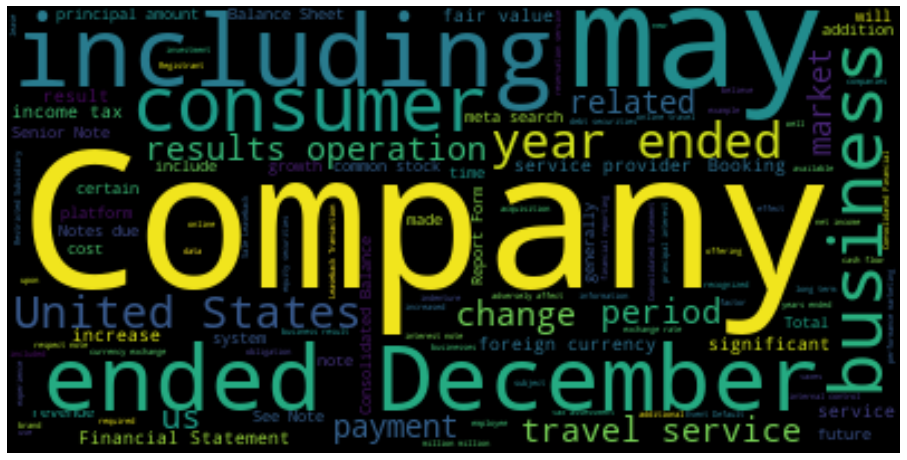

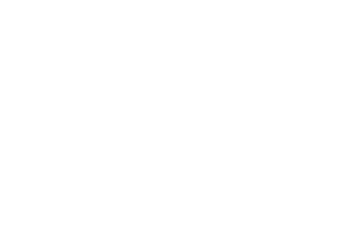

In [34]:
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(raw_pic, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()